# Top-quark pair example analysis

First load the hightea library and the plotting routines

In [1]:
from hightea.client import Interface as hightea
from hightea.plotting import plot,Run

If you would like to store results and job information on your GoogleDrive (see FAQ in Start.ipynb) change the directory here:

In [2]:
USERDIR='.'
#from google.colab import drive
#drive.mount('/content/drive')
#USERDIR='/content/drive/MyDrive/hightea/'

This is an example to perform an analysis with realistic experimental binnings by CMS.

# Download the data and load the binnings of the observables

In [3]:
from numpy import genfromtxt

In [4]:
import os
def download_data(tableid):
    cmd='wget https://www.hepdata.net/download/table/ins1663958/Table%20'+str(tableid)+'/2/csv -O data/table'+str(tableid)+'.csv'
    os.system(cmd)

#download_data(178) # pT(t_hadronic)
#download_data(180) # |y(t_hadronic)|
#download_data(186) # m(tt)
#download_data(190) # |y(tt)|

Now associate the observables we want to compute to the tables. There are top-quark pair observables and there are observables related to the top-quark which decays hadronically or the top-quark which decays leptonically. Since we the charge information we need to avarage over top-quark and anti-top-quark to compare these observables.

Hightea provides the inclusive cross section. The analysis provides the cross section times the branching fraction. We need to divide this factor out when comparing hightea predictions to data.

In [5]:
BR=.2928 # Branching fraction of leptons(mu,e)+hadronic

Relating a descriptive tag to the tables and storing them in dictionaries for simplicity

In [6]:
obs = {
  'ytt' :{'data':'table190.csv'},
  'mtt' :{'data':'table186.csv'}
}

# observables which need avaraging over top and anti-top
obs_avg = {
  'yt' :{'data':'table180.csv'},
  'pTt':{'data':'table178.csv'}
}

Extract the binning from the tables

In [7]:
for ob in obs.keys():
    cur_data = genfromtxt('data/'+obs[ob]['data'], delimiter=',')
    obs[ob]['bins'] = [cur_data[1,1],*cur_data[1:,2]]
for ob in obs_avg.keys():
    cur_data = genfromtxt('data/'+obs_avg[ob]['data'], delimiter=',')
    obs_avg[ob]['bins'] = [cur_data[1,1],*cur_data[1:,2]]

# Do the Hightea analysis

In [8]:
job = hightea('Example-ttbar-job',directory=USERDIR)
job.process('pp_ttx_13TeV')

   pp -> t tbar +X at 13 TeV with mt = 172.5 GeV 

Process tag          :  pp_ttx_13TeV  (use for process specification)
Default scales      :  muR0 = HT/4, muF0 = HT/4
Default pdf         :  NNPDF31_nnlo_as_0118 / 0
Avail. contributions:  ['NNLO', 'NLO', 'LO']
Predefined variables
   pt_top      :  sqrt(p_t_1**2 + p_t_2**2)
   pt_tbar     :  sqrt(p_tbar_1**2 + p_tbar_2**2)
   y_t         :  0.5*log((p_t_0 + p_t_3)/(p_t_0 - p_t_3))
   y_tbar      :  0.5*log((p_tbar_0 + p_tbar_3)/(p_tbar_0 - p_tbar_3))


First define the additional variables:

In [9]:
job.define_new_variable('ytt'   ,'abs(0.5*log((p_t_0+p_tbar_0 + p_t_3 + p_tbar_3)/(p_t_0+p_tbar_0 - p_t_3 - p_tbar_3)))')
job.define_new_variable('mtt'   ,'sqrt((p_t_0+p_tbar_0)**2-(p_t_1+p_tbar_1)**2-(p_t_2+p_tbar_2)**2-(p_t_3+p_tbar_3)**2)')
job.define_new_variable('ayt'   ,'abs(0.5*log((p_t_0 + p_t_3)/(p_t_0 - p_t_3)))')
job.define_new_variable('aytbar','abs(0.5*log((p_tbar_0 + p_tbar_3)/(p_tbar_0 - p_tbar_3)))')

We want to compute the different observables with the already specified binning and for different orders

In [ ]:
orders = ['LO','NLO','NNLO']
for order in orders:
    job.add_histogram()
    job.contribution(order)
    job.description(order+' - ytt')
    job.binning('ytt',obs['ytt']['bins'])
    job.scale_variation('3-point')
    
    job.add_histogram()
    job.contribution(order)
    job.description(order+' - mtt')
    job.binning('mtt',obs['mtt']['bins'])
    job.scale_variation('3-point')

    job.add_histogram()
    job.contribution(order)
    job.description(order+' - ayt')
    job.binning('ayt',obs_avg['yt']['bins'])
    job.scale_variation('3-point')

    job.add_histogram()
    job.contribution(order)
    job.description(order+' - aytbar')
    job.binning('aytbar',obs_avg['yt']['bins'])
    job.scale_variation('3-point')

    job.add_histogram()
    job.contribution(order)
    job.description(order+' - pt_top')
    job.binning('pt_top',obs_avg['pTt']['bins'])
    job.scale_variation('3-point')
    
    job.add_histogram()
    job.contribution(order)
    job.description(order+' - pt_tbar')
    job.binning('pt_tbar',obs_avg['pTt']['bins'])
    job.scale_variation('3-point')

In [ ]:
job.request()

# Plot the results and compare to CMS

In [10]:
hightea_results = job.result()

In [35]:
hightea_ytt_LO   = Run(hightea_results[0])
hightea_ytt_NLO  = Run(hightea_results[6])
hightea_ytt_NNLO = Run(hightea_results[12])
CMS_ytt = Run('data/'+obs['ytt']['data'])/BR

hightea_mtt_LO   = Run(hightea_results[1])
hightea_mtt_NLO  = Run(hightea_results[7])
hightea_mtt_NNLO = Run(hightea_results[13])
CMS_mtt = Run('data/'+obs['mtt']['data'])/BR

hightea_yt_LO   = (Run(hightea_results[2])+Run(hightea_results[3]))/2.
hightea_yt_LO.make_differential()
hightea_yt_NLO  = (Run(hightea_results[8])+Run(hightea_results[9]))/2.
hightea_yt_NLO.make_differential()
hightea_yt_NNLO = (Run(hightea_results[14])+Run(hightea_results[15]))/2.
hightea_yt_NNLO.make_differential()
CMS_yt = Run('data/'+obs_avg['yt']['data'])/BR

hightea_pTt_LO   = (Run(hightea_results[4])+Run(hightea_results[5]))/2.
hightea_pTt_LO.make_differential()
hightea_pTt_NLO  = (Run(hightea_results[10])+Run(hightea_results[11]))/2.
hightea_pTt_NLO.make_differential()
hightea_pTt_NNLO = (Run(hightea_results[16])+Run(hightea_results[17]))/2.
hightea_pTt_NNLO.make_differential()

CMS_pTt = Run('data/'+obs_avg['pTt']['data'])/BR

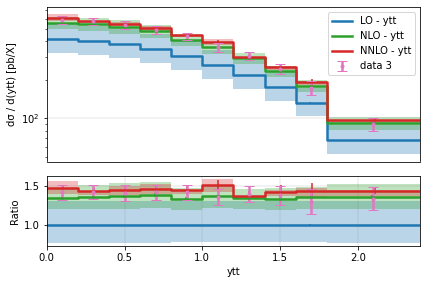

<Figure size 432x288 with 0 Axes>

In [13]:
plot(hightea_ytt_LO,hightea_ytt_NLO,hightea_ytt_NNLO,CMS_ytt,ratio=0,logscale=True)

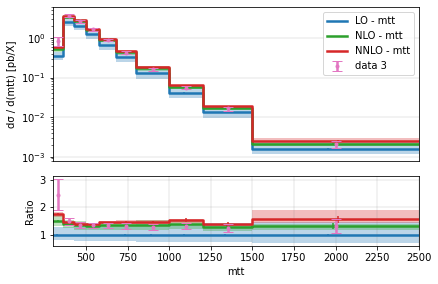

<Figure size 432x288 with 0 Axes>

In [14]:
plot(hightea_mtt_LO,hightea_mtt_NLO,hightea_mtt_NNLO,CMS_mtt,ratio=0,logscale=True)

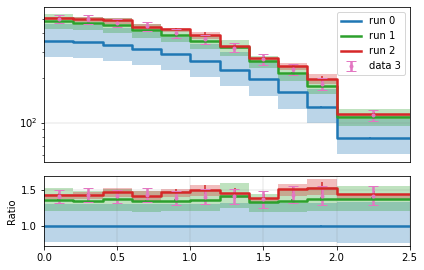

<Figure size 432x288 with 0 Axes>

In [36]:
plot(hightea_yt_LO,hightea_yt_NLO,hightea_yt_NNLO,CMS_yt,ratio=0,logscale=True)

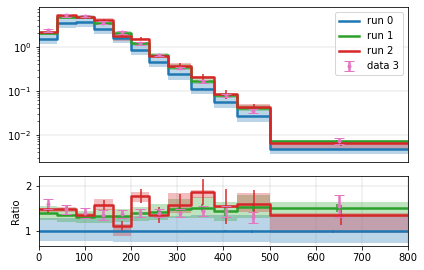

<Figure size 432x288 with 0 Axes>

In [37]:
plot(hightea_pTt_LO,hightea_pTt_NLO,hightea_pTt_NNLO,CMS_pTt,ratio=0,logscale=True)